In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [2]:
df = yf.download('TSLA', period='1y', interval='1h')[['Open', 'High', 'Low', 'Close']]

df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close
Ticker,TSLA,TSLA,TSLA,TSLA
Datetime,,,,
2024-03-06 16:30:00+00:00,176.612595,178.990005,176.059998,178.660004
2024-03-06 17:30:00+00:00,178.669998,179.990005,178.070007,179.880096
2024-03-06 18:30:00+00:00,179.899994,180.050003,176.309998,177.074997
2024-03-06 19:30:00+00:00,177.089996,178.117096,176.455597,177.220001
2024-03-06 20:30:00+00:00,177.229996,177.240005,176.190002,176.500000
...,...,...,...,...
2025-03-05 19:30:00+00:00,277.000000,278.139893,273.519989,276.820007
2025-03-05 20:30:00+00:00,276.739990,279.540009,275.260010,279.260010


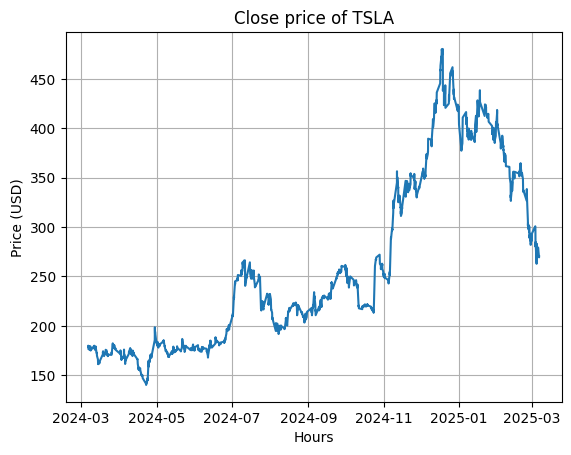

In [3]:
import matplotlib.pyplot as plt

plt.plot(df['Close'])
plt.title("Close price of TSLA")
plt.grid(True)
plt.xlabel("Hours")
plt.ylabel("Price (USD)")
plt.show()


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

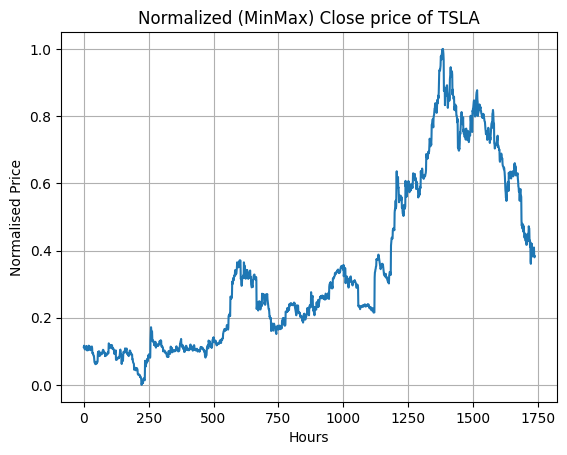

In [5]:
plt.plot(scaled_data)
plt.title("Normalized (MinMax) Close price of TSLA")
plt.grid(True)
plt.xlabel("Hours")
plt.ylabel("Normalised Price")
plt.show()

In [6]:
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [7]:
# Create sequences for training with a look-back of 60 time steps (for 60 hours)
look_back = 60
X, y = create_sequences(scaled_data, look_back)

In [8]:
# Reshape the data for RNN input: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Convert data to PyTorch tensors
X = torch.Tensor(X)
y = torch.Tensor(y)

In [14]:
# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
# Define the vanilla RNN model in PyTorch
class VanillaRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(VanillaRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

In [11]:
# Initialize the model, loss function, and optimizer
model = VanillaRNN(input_size=1, hidden_size=50, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [1/1000], Loss: 0.1000
Epoch [2/1000], Loss: 0.0836
Epoch [3/1000], Loss: 0.0705
Epoch [4/1000], Loss: 0.0600
Epoch [5/1000], Loss: 0.0519
Epoch [6/1000], Loss: 0.0462
Epoch [7/1000], Loss: 0.0426
Epoch [8/1000], Loss: 0.0409
Epoch [9/1000], Loss: 0.0408
Epoch [10/1000], Loss: 0.0414
Epoch [11/1000], Loss: 0.0419
Epoch [12/1000], Loss: 0.0417
Epoch [13/1000], Loss: 0.0409
Epoch [14/1000], Loss: 0.0395
Epoch [15/1000], Loss: 0.0378
Epoch [16/1000], Loss: 0.0361
Epoch [17/1000], Loss: 0.0346
Epoch [18/1000], Loss: 0.0334
Epoch [19/1000], Loss: 0.0325
Epoch [20/1000], Loss: 0.0318
Epoch [21/1000], Loss: 0.0314
Epoch [22/1000], Loss: 0.0310
Epoch [23/1000], Loss: 0.0305
Epoch [24/1000], Loss: 0.0299
Epoch [25/1000], Loss: 0.0292
Epoch [26/1000], Loss: 0.0282
Epoch [27/1000], Loss: 0.0271
Epoch [28/1000], Loss: 0.0259
Epoch [29/1000], Loss: 0.0247
Epoch [30/1000], Loss: 0.0235
Epoch [31/1000], Loss: 0.0223
Epoch [32/1000], Loss: 0.0212
Epoch [33/1000], Loss: 0.0201
Epoch [34/1000], Lo

[[0.88170266]
 [0.8648852 ]
 [0.8491715 ]
 [0.8450626 ]
 [0.8478818 ]
 [0.8528781 ]
 [0.8581536 ]
 [0.8584396 ]
 [0.8574675 ]
 [0.8703908 ]
 [0.8912301 ]
 [0.9099376 ]
 [0.9261154 ]
 [0.93387353]
 [0.9337418 ]
 [0.9312118 ]
 [0.92711526]
 [0.92586106]
 [0.92472285]
 [0.90922284]
 [0.89174736]
 [0.87759393]
 [0.86775386]
 [0.85901207]
 [0.85401344]
 [0.85324484]
 [0.84550834]
 [0.83630913]
 [0.830428  ]
 [0.82894754]
 [0.8301041 ]
 [0.83000004]
 [0.82651335]
 [0.8258169 ]
 [0.8213087 ]
 [0.81398743]
 [0.80684453]
 [0.79867697]
 [0.79346305]
 [0.78788507]
 [0.7658757 ]
 [0.7398032 ]
 [0.7195124 ]
 [0.7069776 ]
 [0.6993468 ]
 [0.6982657 ]
 [0.70059204]
 [0.7076796 ]
 [0.7239988 ]
 [0.74012405]
 [0.75351334]
 [0.7668752 ]
 [0.7807765 ]
 [0.7921401 ]
 [0.80307096]
 [0.80799156]
 [0.80616796]
 [0.79989094]
 [0.7918955 ]
 [0.7873104 ]
 [0.7889143 ]
 [0.78284353]
 [0.7733015 ]
 [0.763319  ]
 [0.75917345]
 [0.75529635]
 [0.74990237]
 [0.7473278 ]
 [0.7487277 ]
 [0.7505887 ]
 [0.7471436 ]
 [0.74

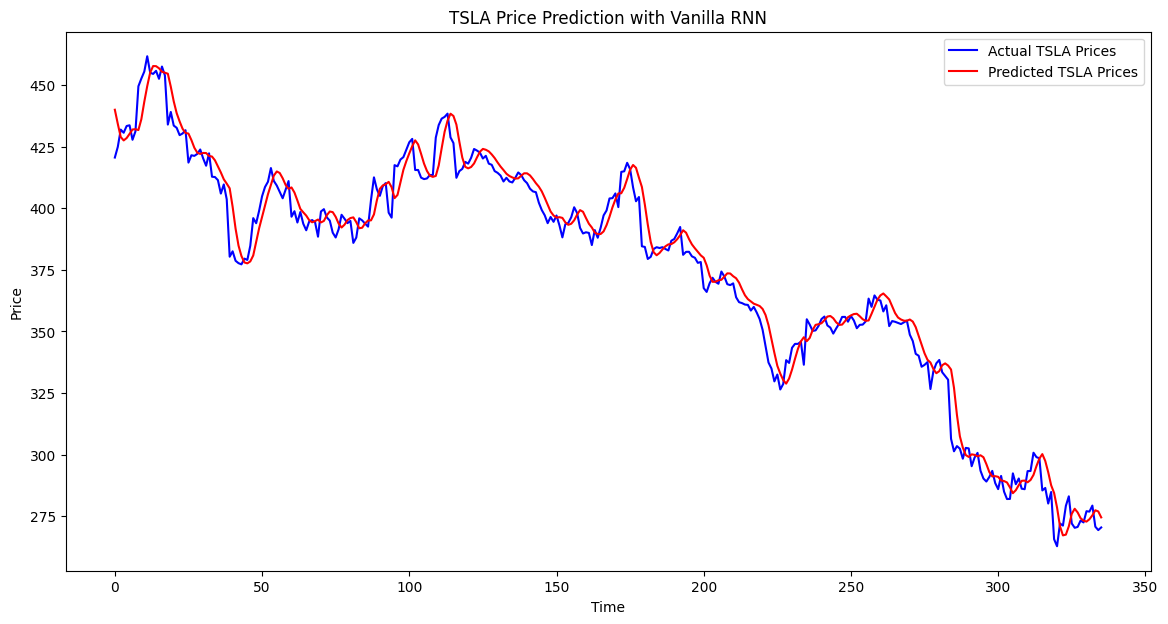

In [13]:
# Make predictions
model.eval()
predictions = model(X_test).detach().numpy()

print(predictions)

# Inverse scale the predictions and the actual values to get actual prices
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test.view(-1, 1))

# Plot the results
plt.figure(figsize=(14, 7))

# Plot actual vs predicted prices
plt.plot(actual_prices, color='blue', label='Actual TSLA Prices')
plt.plot(predicted_prices, color='red', label='Predicted TSLA Prices')
plt.title('TSLA Price Prediction with Vanilla RNN')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
